In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [17]:
data = pd.read_csv("c:/Users/nisha/Downloads/traffic.csv/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [19]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

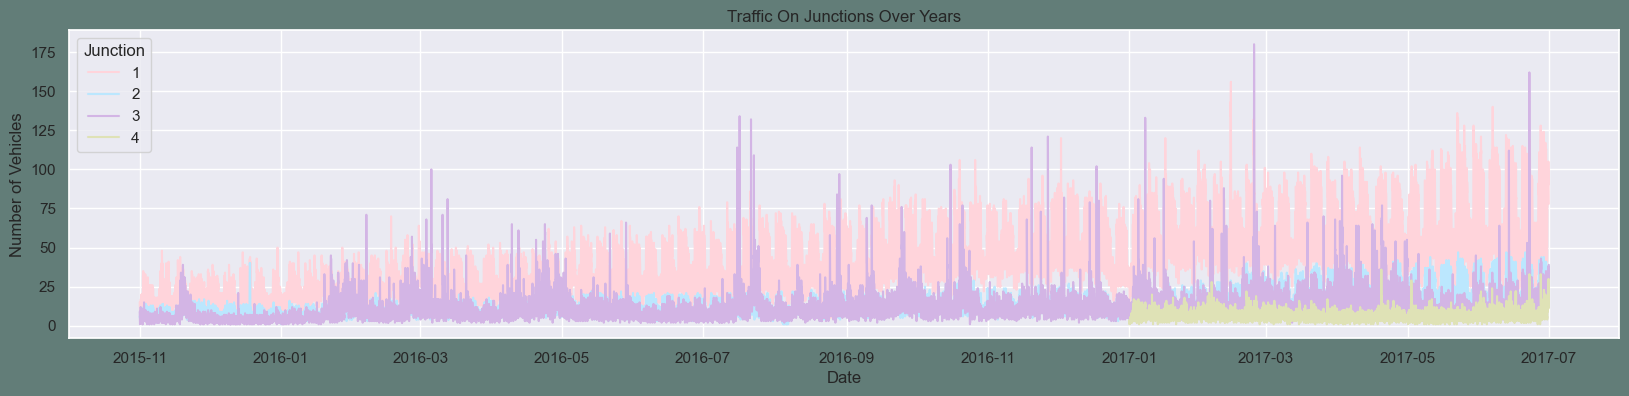

In [21]:
sns.set_theme()

#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [23]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


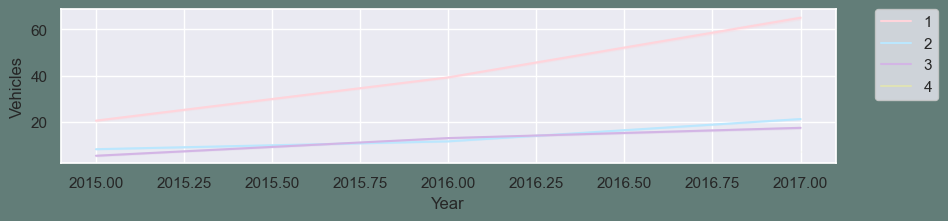

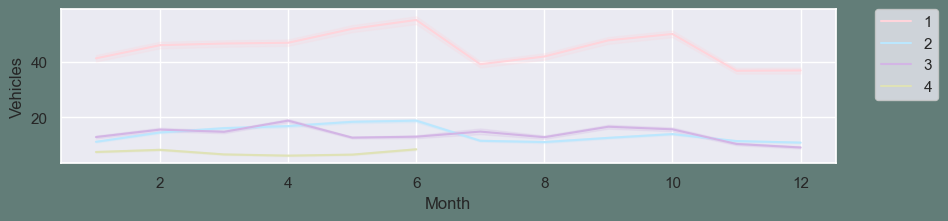

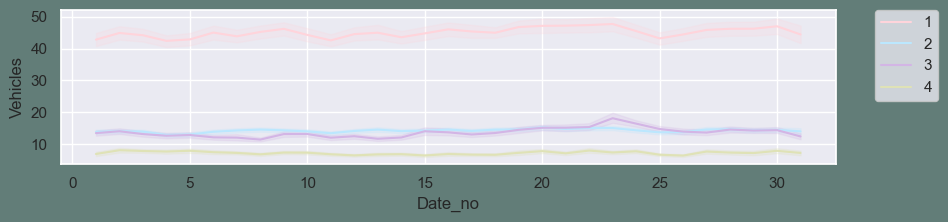

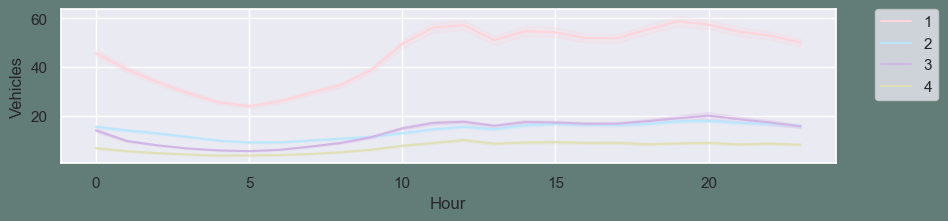

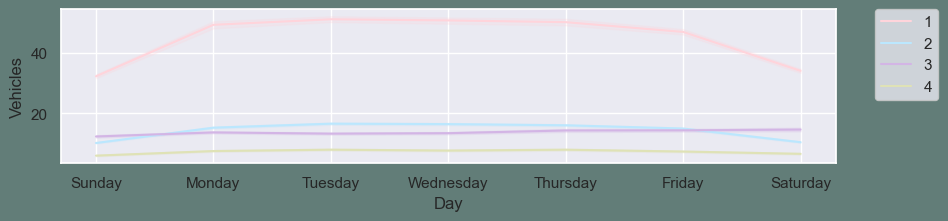

In [25]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

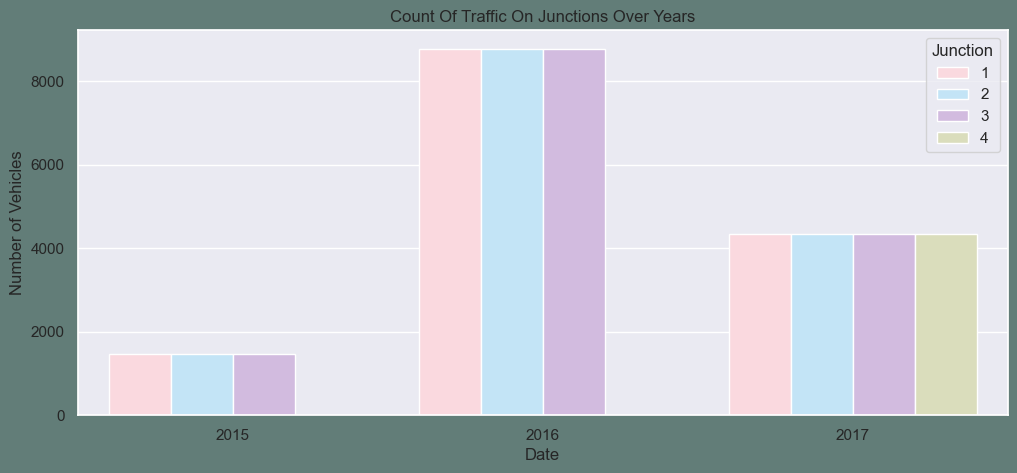

In [26]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

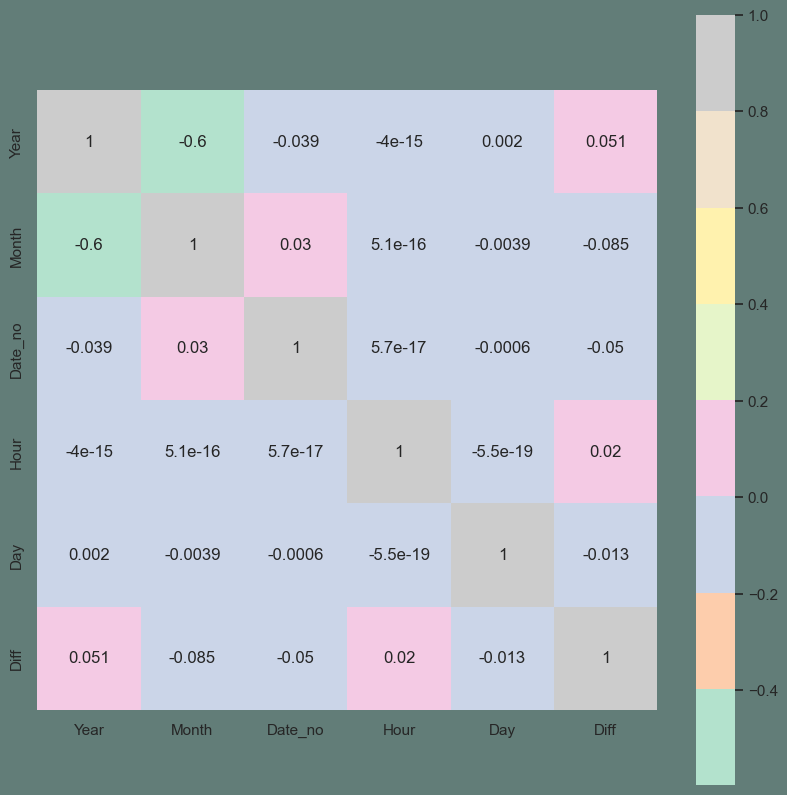

In [195]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

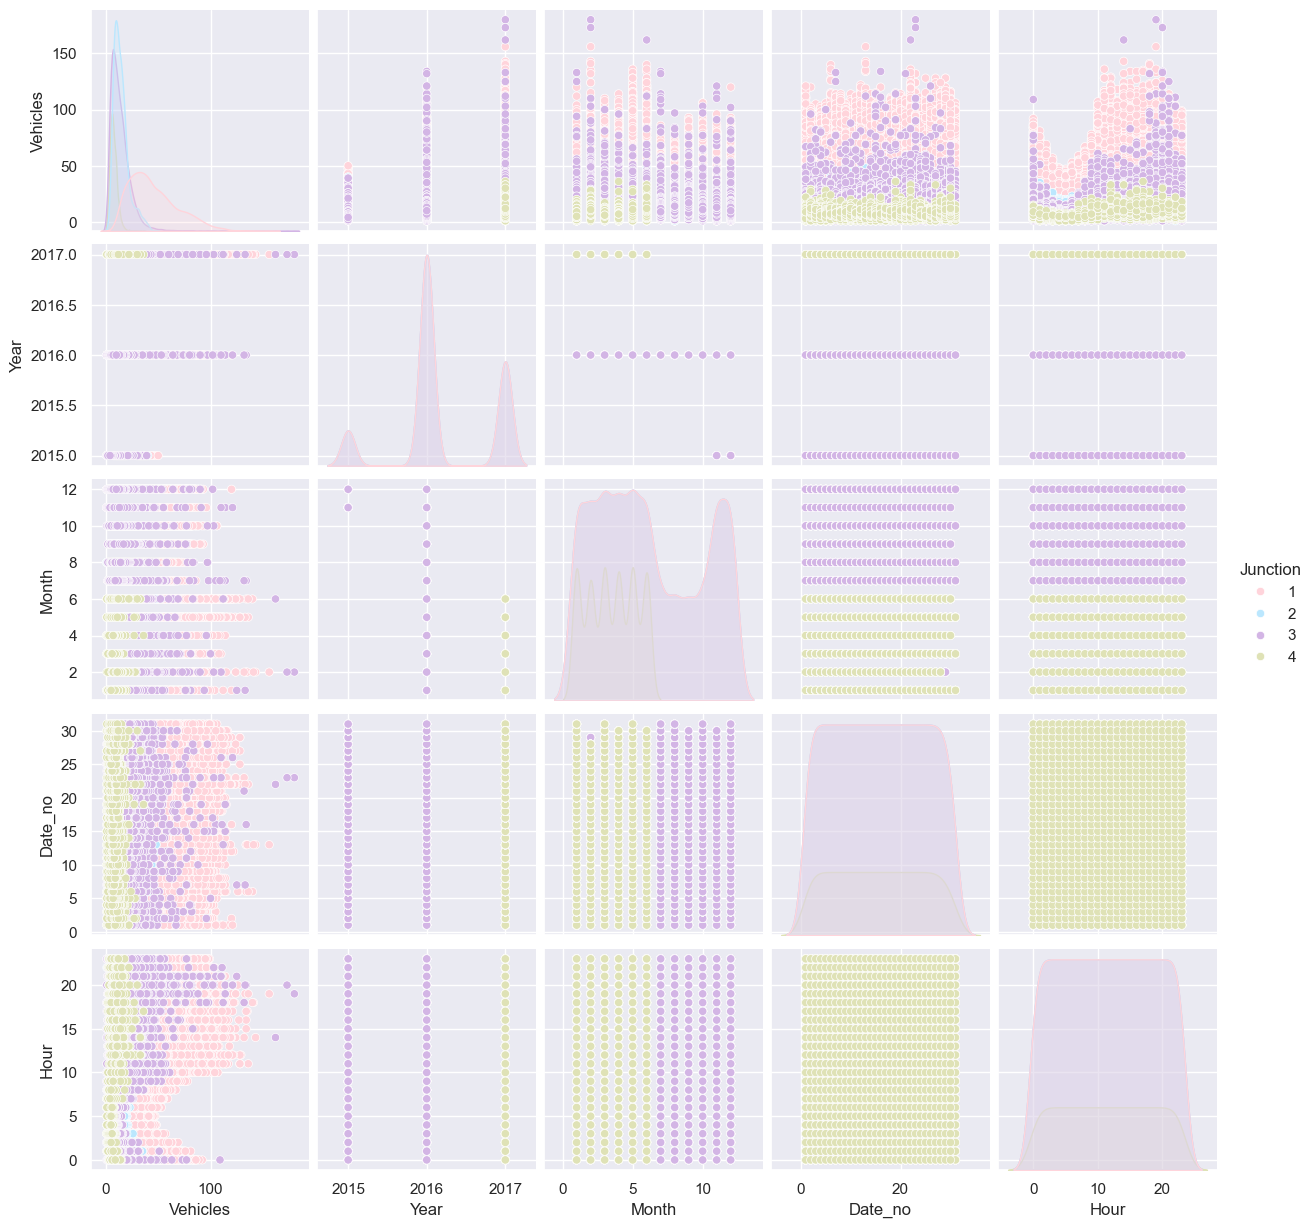

In [33]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [34]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [37]:
df_J

Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]

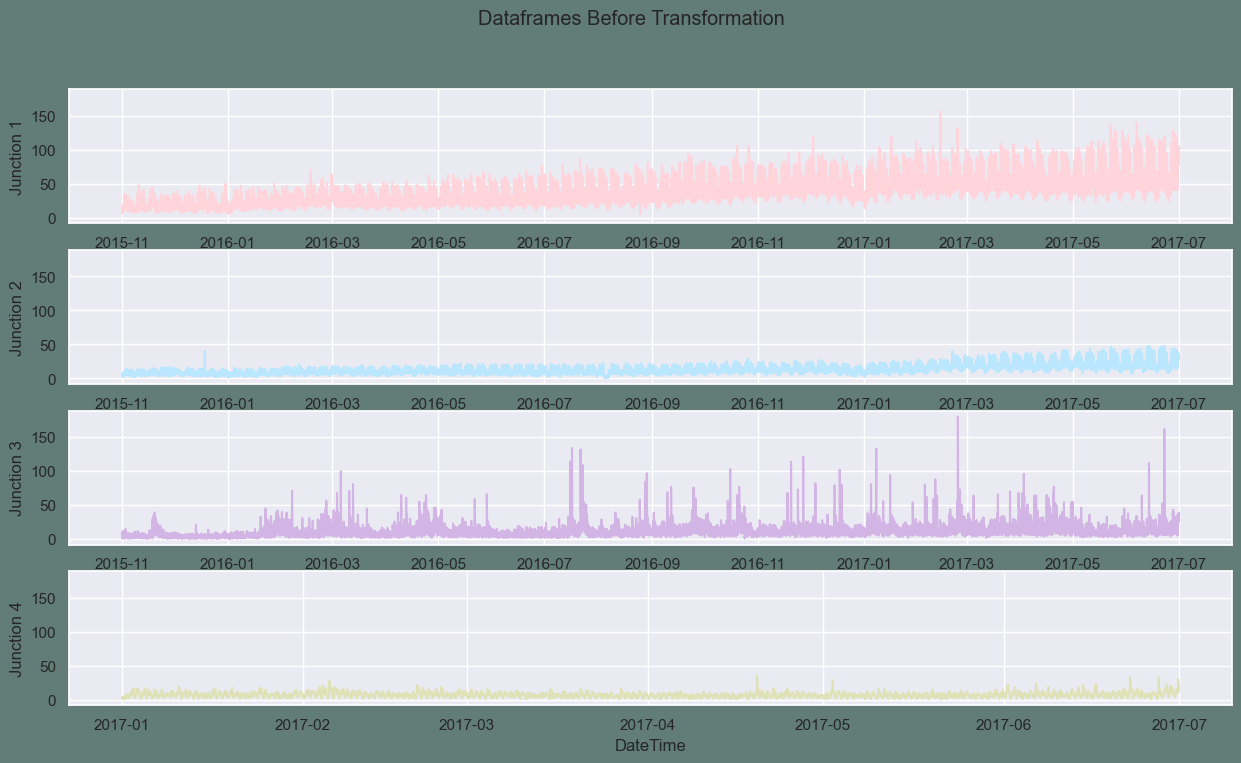

In [39]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [60]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df[ col ] = df_normalized
    df_normalized = df_normalized.to_frame()
    #df = df.to_frame()
    return df, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [64]:
df

,Junction,Vehicles,Year,Month,Date_no,Hour,Day
DateTime,,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...
2017-06-30 19:00:00,4,11,2017,6,30,19,Friday
2017-06-30 20:00:00,4,30,2017,6,30,20,Friday
2017-06-30 21:00:00,4,16,2017,6,30,21,Friday


In [68]:
df = df[ df[ "Junction" ] == 1]
df

,Junction,Vehicles,Year,Month,Date_no,Hour,Day
DateTime,,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...
2017-06-30 19:00:00,1,105,2017,6,30,19,Friday
2017-06-30 20:00:00,1,96,2017,6,30,20,Friday
2017-06-30 21:00:00,1,90,2017,6,30,21,Friday


In [70]:
df.dtypes

Junction     int64
Vehicles     int64
Year         int32
Month        int32
Date_no      int32
Hour         int32
Day         object
dtype: object

In [72]:
df[ "Day" ] = df[ "Day" ].astype( str ).replace( { "Monday" : 1 , "Tuesday" : 2 , "Wednesday" : 3 , "Thursday" : 4 , "Friday" : 5 , "Saturday" : 6 , "Sunday" : 7 } )

In [74]:
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

In [76]:
df, av, std = Normalize(df, "Vehicles")
Diff = Difference(df, col="Vehicles", interval= ( 24 * 7 )) #taking an hour's diffrence
df = df[1:]
df.columns = [ i if i != "Vehicles" else "Norm" for i in df.columns]

In [78]:
df = df.tail( len( Diff))

df["Diff"]= Diff

In [80]:
df.shape

(14424, 8)

In [82]:
df

,Junction,Norm,Year,Month,Date_no,Hour,Day,Diff
DateTime,,,,,,,,
2015-11-08 00:00:00,1,-1.393099,2015,11,8,0,7,-0.086925
2015-11-08 01:00:00,1,-1.262712,2015,11,8,1,7,0.130387
2015-11-08 02:00:00,1,-1.480024,2015,11,8,2,7,0.043462
2015-11-08 03:00:00,1,-1.610412,2015,11,8,3,7,0.043462
2015-11-08 04:00:00,1,-1.523487,2015,11,8,4,7,0.043462
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,1,2.605450,2017,6,30,19,5,0.478087
2017-06-30 20:00:00,1,2.214288,2017,6,30,20,5,0.260775
2017-06-30 21:00:00,1,1.953513,2017,6,30,21,5,0.391162


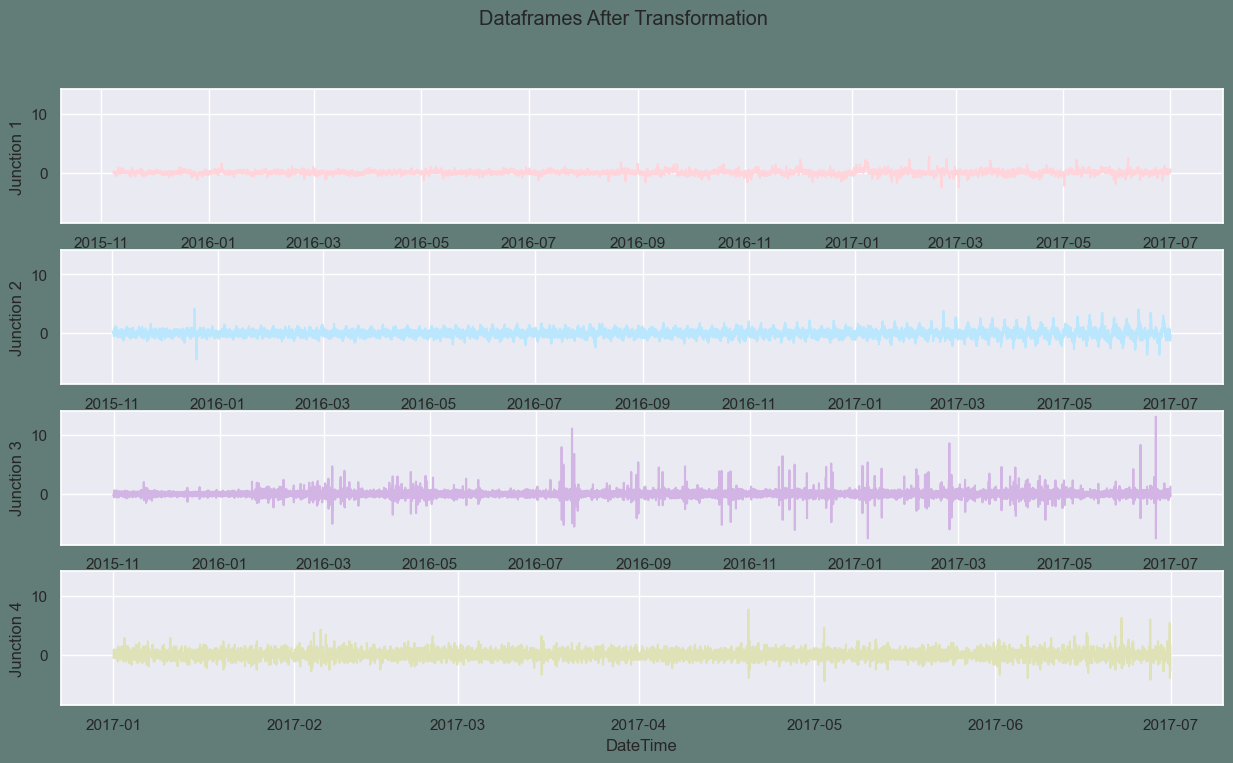

In [84]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [86]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415426
p-value: 4.7985398763968885e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694006
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908833154
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305268
p-value: 2.778787532594624e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [88]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, df.shape[ 1 ]), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [90]:
df

,Junction,Norm,Year,Month,Date_no,Hour,Day,Diff
DateTime,,,,,,,,
2015-11-08 00:00:00,1,-1.393099,2015,11,8,0,7,-0.086925
2015-11-08 01:00:00,1,-1.262712,2015,11,8,1,7,0.130387
2015-11-08 02:00:00,1,-1.480024,2015,11,8,2,7,0.043462
2015-11-08 03:00:00,1,-1.610412,2015,11,8,3,7,0.043462
2015-11-08 04:00:00,1,-1.523487,2015,11,8,4,7,0.043462
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,1,2.605450,2017,6,30,19,5,0.478087
2017-06-30 20:00:00,1,2.214288,2017,6,30,20,5,0.260775
2017-06-30 21:00:00,1,1.953513,2017,6,30,21,5,0.391162


In [92]:
df = df.drop( [ "Junction" , "Norm" ] , axis = 1 )

In [94]:
df

,Year,Month,Date_no,Hour,Day,Diff
DateTime,,,,,,
2015-11-08 00:00:00,2015,11,8,0,7,-0.086925
2015-11-08 01:00:00,2015,11,8,1,7,0.130387
2015-11-08 02:00:00,2015,11,8,2,7,0.043462
2015-11-08 03:00:00,2015,11,8,3,7,0.043462
2015-11-08 04:00:00,2015,11,8,4,7,0.043462
...,...,...,...,...,...,...
2017-06-30 19:00:00,2017,6,30,19,5,0.478087
2017-06-30 20:00:00,2017,6,30,20,5,0.260775
2017-06-30 21:00:00,2017,6,30,21,5,0.391162


In [96]:
df = df.dropna()

J_train, J_test = Split_data(df)

In [98]:
J_train

array([[ 2.01500000e+03,  1.10000000e+01,  8.00000000e+00,
         0.00000000e+00,  7.00000000e+00, -8.69249826e-02],
       [ 2.01500000e+03,  1.10000000e+01,  8.00000000e+00,
         1.00000000e+00,  7.00000000e+00,  1.30387474e-01],
       [ 2.01500000e+03,  1.10000000e+01,  8.00000000e+00,
         2.00000000e+00,  7.00000000e+00,  4.34624913e-02],
       ...,
       [ 2.01700000e+03,  5.00000000e+00,  1.00000000e+00,
         1.80000000e+01,  1.00000000e+00, -7.82324843e-01],
       [ 2.01700000e+03,  5.00000000e+00,  1.00000000e+00,
         1.90000000e+01,  1.00000000e+00, -6.51937369e-01],
       [ 2.01700000e+03,  5.00000000e+00,  1.00000000e+00,
         2.00000000e+01,  1.00000000e+00, -5.21549895e-01]])

In [162]:
#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, :  ])
        y.append(df[i, -1 ])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    if train.ndim == 3 and test.ndim == 3:
        return train, test

    n_features = train.shape[1]
    train = np.reshape(train, (train.shape[0], train.shape[1], n_features))
    test = np.reshape(test, (test.shape[0],test.shape[1],n_features))
    return train, test

In [164]:
#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, df.shape[ 1 ]), test.values.reshape(-1, df.shape[ -1 ])
    return train, test

In [166]:
X_train, y_train = TnF(J_train)
X_test, y_test = TnF(J_test)


In [168]:
276032 / 8626

32.0

In [170]:
X_train.shape

(12949, 32, 6)

In [172]:
X_test.shape

(8626, 32, 1)

In [189]:
import tensorflow as tf


#Model for the prediction
def LSTM_Prediction_Traffic_System_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],6), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    
    
    """
    model.add(LSTM(100, return_sequences = True , input_shape=(X_Train.shape[1], X_Train.shape[2]) , activation = "tanh" ))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences = True , input_shape=(X_Train.shape[1], 1) , activation = "tanh" ))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences = True , input_shape=(X_Train.shape[1], 1) , activation = "tanh" ))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences = True , input_shape=(X_Train.shape[1], 1) , activation = "tanh" ))
    model.add(Dropout(0.2))
    model.add( Dense( 50 ) )
    model.add( Dropout( 0.2 ) )
    model.add( Dense( 50 ) )
    model.add( Dropout( 0.2 ) )
    #model.add(LSTM(70)) 
    #model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.SGD(decay=1e-7, momentum=0.9))
    """
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU , model

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [191]:
y_train.shape

(12949,)

In [193]:
Pred , model = LSTM_Prediction_Traffic_System_model(X_train,y_train,X_test)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 96s 816ms/step - loss: 0.1080
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 832ms/step - loss: 0.1029
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 77s 778ms/step - loss: 0.1020
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 83s 787ms/step - loss: 0.1020
Epoch 5/50
12/87 ━━━━━━━━━━━━━━━━━━━━ 43s 580ms/step - loss: 0.1025

KeyboardInterrupt: 

In [ ]:
model.save_weights('./Best_Model_Traffic_Detection_Prediction')

In [ ]:
y_test.shape

In [ ]:
Pred.shape

In [ ]:
y_train

In [ ]:
Pred

In [ ]:
RMSE_J1=RMSE_Value(y_test,Pred[ : , 1])
PredictionsPlot(y_test,Pred,0)